In [1]:
import numpy as np
import xarray as xr

We set up the finite-difference numeric integration (using vanilla runge-kutta 4th order), because it's simpler than understanding a scipy blackbox.

We'll use the Fitz-Hugh Nagumo equations, a simplified model of the action potential at a given point along an axon. $v$ is the voltage drop along the membrane (relative to its resting value), and $w$ is the inactivation of the Na+ channels.

$\frac{dv}{dt} = v - v^3 / 3 - w + I$

$\frac{dw}{dt} = \frac{1}{\gamma}(v + a - bw)$

We investigate the effects of the parameters $a,b,\gamma$ on the behavior of the system. ($I$ is a constant input voltage, which drives the system on its remarkable sojourn.)

In [2]:
# system simulator
    
# excerpts https://github.com/andyr0id/theano-rk4/blob/master/rk4.py
# simplified: no explicit time dependence

def rk4_step_exp(y0, h, dydt, **args):
    k1 = dydt(*y0, **args) * h

    y2 = y0 + (k1/2)
    k2 = dydt(*y2, **args) * h

    y3 = y0 + (k2/2)
    k3 = dydt(*y3, **args) * h

    y4 = y0 + k3
    k4 = dydt(*y4, **args) * h

    dy = (k1 + 2*k2 + 2*k3 + k4)/6
    return dy

def f(v,w, I,a,b,gam):
    dvdt = v - v**3 / 3 - w + I
    dwdt = (v + a - b*w) / gam
    return np.array([dvdt, dwdt])

In [6]:
y = (.1,.1)

tr = np.zeros((20,2))
tr[0] = y
for i in range(1,20):
    dy = rk4_step_exp(y, .8, f, a=.1, b=.4, I=.3, gam=1) # h = .2
    y += dy
    tr[i] = y
    
tr

array([[ 0.1       ,  0.1       ],
       [ 0.36884311,  0.30445292],
       [ 0.60113048,  0.63271504],
       [ 0.63741668,  0.96635156],
       [ 0.41009894,  1.13949966],
       [-0.0935774 ,  1.01060586],
       [-0.79520513,  0.48525732],
       [-1.15868041, -0.28679922],
       [-0.94933504, -0.88187606],
       [-0.35760237, -1.02850051],
       [ 0.65312575, -0.57865004],
       [ 1.44674545,  0.43041859],
       [ 1.30402714,  1.3570191 ],
       [ 0.77202491,  1.77012088],
       [-0.11215292,  1.5871863 ],
       [-1.24429873,  0.71650359],
       [-1.45145376, -0.39665654],
       [-1.04077669, -1.08563132],
       [-0.29695687, -1.18412485],
       [ 0.88212042, -0.58380884]])

Great, it looks like we have something. Something oscillatory, as expected.

Let's wrap the simulation in a one-liner and run it a bunch of times, sweeping out a line in parameter space (along $\gamma \in [0.1,2.0]$, in this case). We'll return the entire time-series trace, and feed the 2d dataset to *xarray*.

In [13]:
args = {'a':.1, 'b':.4, 'I':.3}

def trace(y, h, T, **args):
    tr = np.zeros((T,2))
    tr[0] = y
    for i in range(1,T):
        dy = rk4_step_exp(y, h, f, **args)
        y += dy
        tr[i] = y
        
    return tr

y = (.1,.1)
us = np.linspace(.1,2,20)
dat = np.array( [trace(y, .8, 40, gam=u, **args) for u in us] ) # T = 40

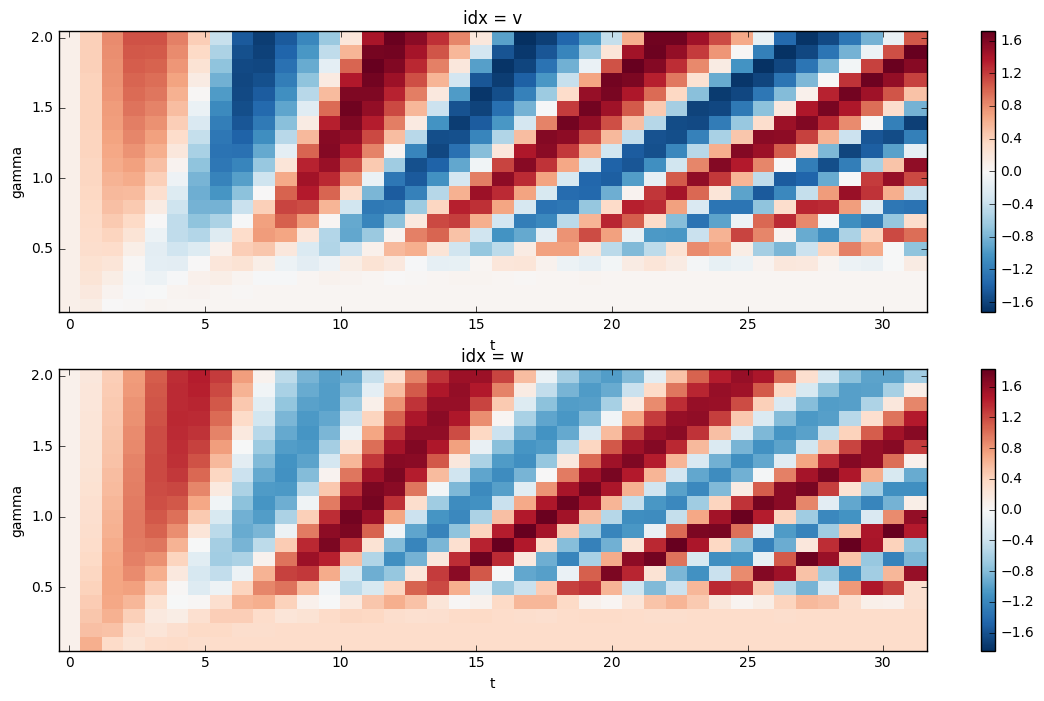

In [14]:
# np.linspace(0,1,11)

ds = xr.DataArray(dat, [('gamma', us),
                        ('t', np.arange(0,40*.8,.8)),
                        ('idx', ['v', 'w'])])

import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14,8))
ds.sel(idx='v').plot(ax=ax1)
ds.sel(idx='w').plot(ax=ax2)

# voltage vs recovery

It looks like $\gamma$ just slows down the oscillations, by scaling the rate of inactivation.

Let's investigate $a,b$, and whether they have any interesting interactions. We don't have a natural 'end time' to sample at, so will make a simple guess and take timeslices at fixed intervals.

In [20]:
args = {'I':.3, 'gam':1}
us = np.linspace(.1,1,10)
vs = np.linspace(.1,1,10)
# reassigning vars, be careful

dat = np.array( [[trace(y, .4, 80, a=u, b=v, **args) for u in us] for v in vs] ) # .2, 40

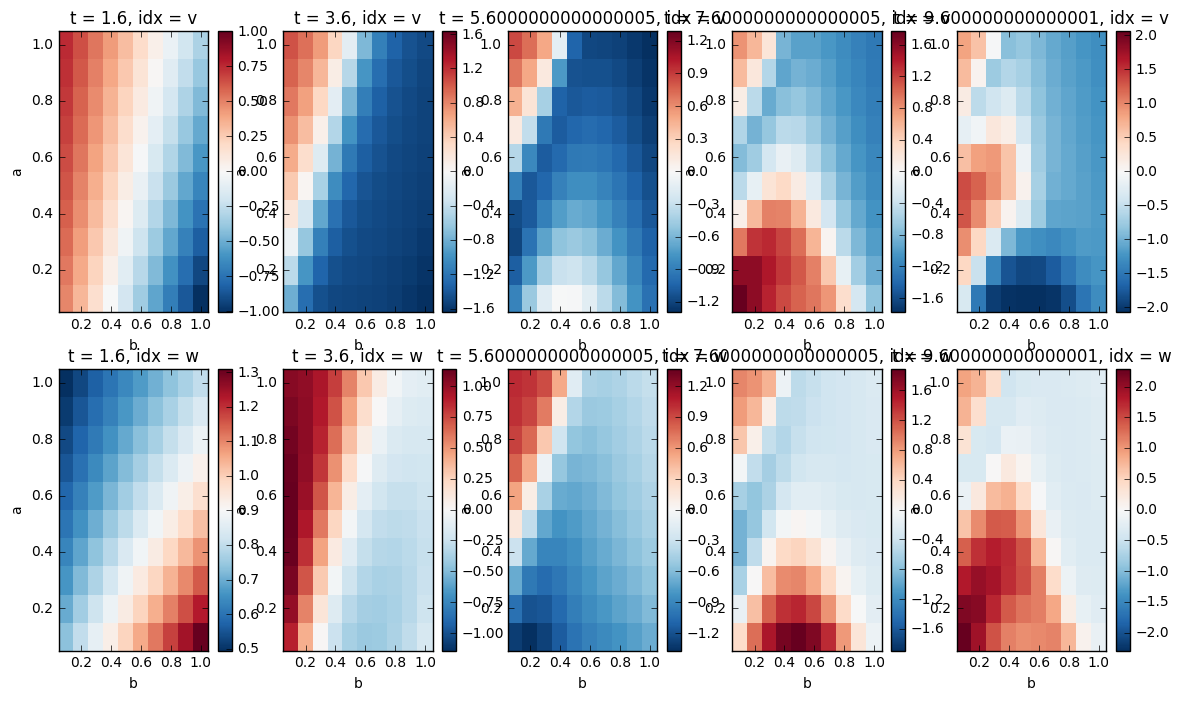

In [24]:
ds = xr.DataArray(dat, [('a', us),
                        ('b', vs),
                        ('t', np.arange(0,.4*80,.4)),
                        ('idx', ['v', 'w'])])

import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(14,8))
for coord,row in zip(['v','w'],axs):
    for i,ax in zip([5,10,15,20,25], row):
        ds.sel(idx=coord).isel(t=i-1).plot(ax=ax, cmap='RdBu_r')
    
# ds.sel(idx='v').isel(t=-1).plot(ax=ax1)
# ds.sel(idx='w').isel(t=-1).plot(ax=ax2)

That's not easy to interpret! A common downside of abstraction.

Let's go back down a level of abstraction, and examine a timeseries from each corner.

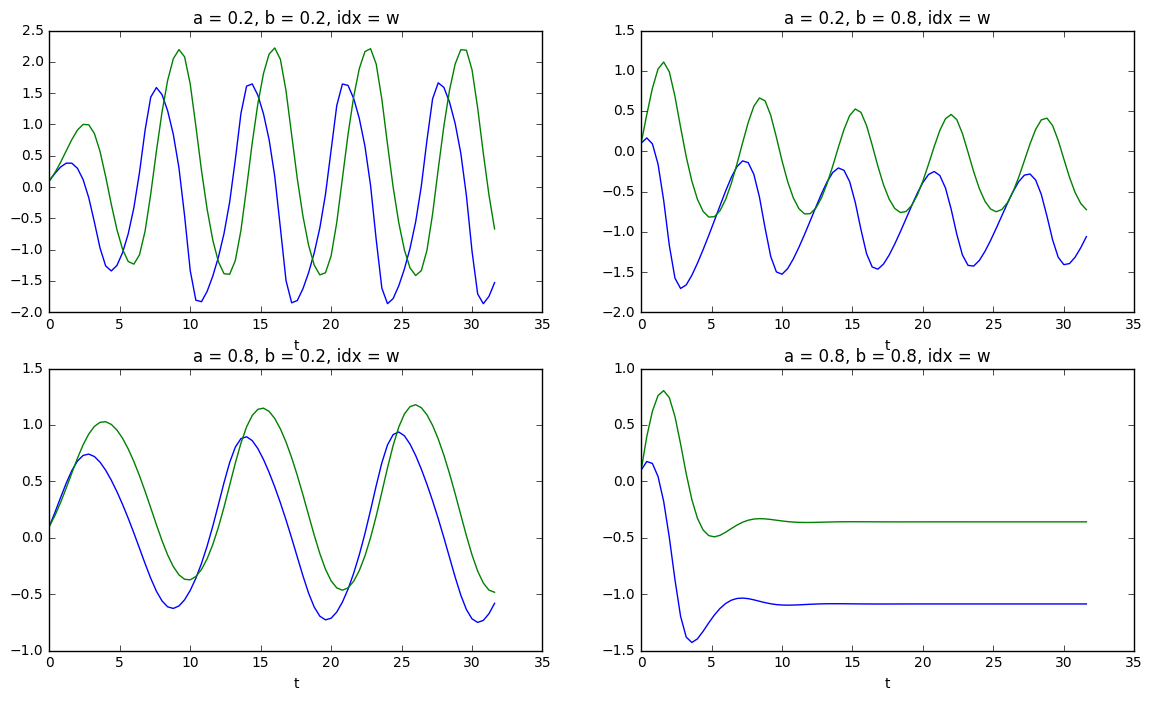

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(14,8))

ds.sel(a=.2,b=.2,idx='v').plot(ax=ax1)
ds.sel(a=.2,b=.2,idx='w').plot(ax=ax1)

ds.sel(a=.2,b=.8,idx='v').plot(ax=ax2)
ds.sel(a=.2,b=.8,idx='w').plot(ax=ax2)

ds.sel(a=.8,b=.2,idx='v').plot(ax=ax3)
ds.sel(a=.8,b=.2,idx='w').plot(ax=ax3)

ds.sel(a=.8,b=.8,idx='v').plot(ax=ax4) # sel(..., method='nearest')
ds.sel(a=.8,b=.8,idx='w').plot(ax=ax4)

Well, increased $a$ ~~certainly dampens~~ reduces the lag of our inactivation response, even to the point of losing our oscilliations. Increased $b$ seems to... eh...

At any point in this pipeline, we can go back and tweak time horizons, parameter sweep intervals, and so forth, to make the data clearer. So we don't need a perfect experimental design right off the bat.

This analysis is a bit easier since we can peek at the equations to see what the parameters are really doing. At the same time, spooling it out gives us a better idea of what the equations properly mean.

---

I've gone back and lengthened the time horizon ($h$\*=2, $T$\*=2) on our later runs. Some of the old values I worked from are in the margins, commented out. *Because of the pipelined design, it's relatively safe to revise without making a whole new copy of the experiment.*

Notice that I've cheated by not declaring my constants $h,T$! I need to be careful to keep these consistent within each stage of the experiment. But I can keep track an entire stage at once - not necessarily the entire pipeline, - because the functional code is so concise.

Now we can see that increased $b$ makes inactivation recover much faster. But this tends to dampen the oscillations.